In [ ]:
'''
Deep Learning Stock Price Predictor 
Author: Gil Akos
Objective: Create Deep Learning Model with Keras LSTM
Reference: http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
'''

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Import required libraries for Machine Learning
import math
import numpy as np
# Fix random seed for reproducibility
np.random.seed(7)
import pandas as pd

# Import Keras Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.metrics import mean_squared_error

# Import required libraries for Yahoo Finance API
import yahoo_finance as yf
from yahoo_finance import Share

# Import required libraries for visualization and printing
from pprint import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (14, 12)
import matplotlib.dates as mdates
import datetime

Using TensorFlow backend.


In [73]:
# Set Benchmark Dates based on Machine Learning for Trading course 1/1/09-6/18/15
date_start, date_end = '2009-01-01', '2015-06-18'

# Set Additional Tickers
tick_0 = 'SPY'
tick_1 = 'GE'
tick_2 = 'MSFT'
tick_3 = 'AAPL'

# Set Baseline Model Ticker
base_ticker = tick_0

In [74]:
#Request Stock Data
stock_data = Share(base_ticker)
stock_historical = stock_data.get_historical(date_start,date_end)

#pprint(stock_historical)

#Define columns of data to keep from historical stock data
stock_item = []
stock_date = []
stock_close = []
stock_volume = []

#Loop through the stock data objects backwards and store factors we want to keep
i_counter = 0
for i in xrange(len(stock_historical)-1,-1,-1):
    d = stock_historical[i]
    stock_item.append(i_counter)
    stock_date.append(d['Date'])
    stock_close.append(d['Adj_Close'])
    stock_volume.append(d['Volume'])
    i_counter += 1

#Create a dataframe for stock data
stock_df = pd.DataFrame()
    
#Add factors to dataframe
stock_df['Item'] = stock_item
stock_df['Date'] = stock_date
stock_df['Adj_Close'] = pd.to_numeric(stock_close)
stock_df['Volume'] = pd.to_numeric(stock_volume)

#Print the dataframe head and tail
print(stock_df.head())
print("---")
print(stock_df.tail())

   Item        Date  Adj_Close     Volume
0     0  2009-01-02  78.738477  227566300
1     1  2009-01-05  78.645305  240349700
2     2  2009-01-06  79.170456  328260900
3     3  2009-01-07  76.798813  280899200
4     4  2009-01-08  77.112211  263834400
---
      Item        Date   Adj_Close     Volume
1621  1621  2015-06-12  202.337412  135382400
1622  1622  2015-06-15  201.470299  124384200
1623  1623  2015-06-16  202.568649   85308200
1624  1624  2015-06-17  202.896224  126708600
1625  1625  2015-06-18  205.006216  165867900


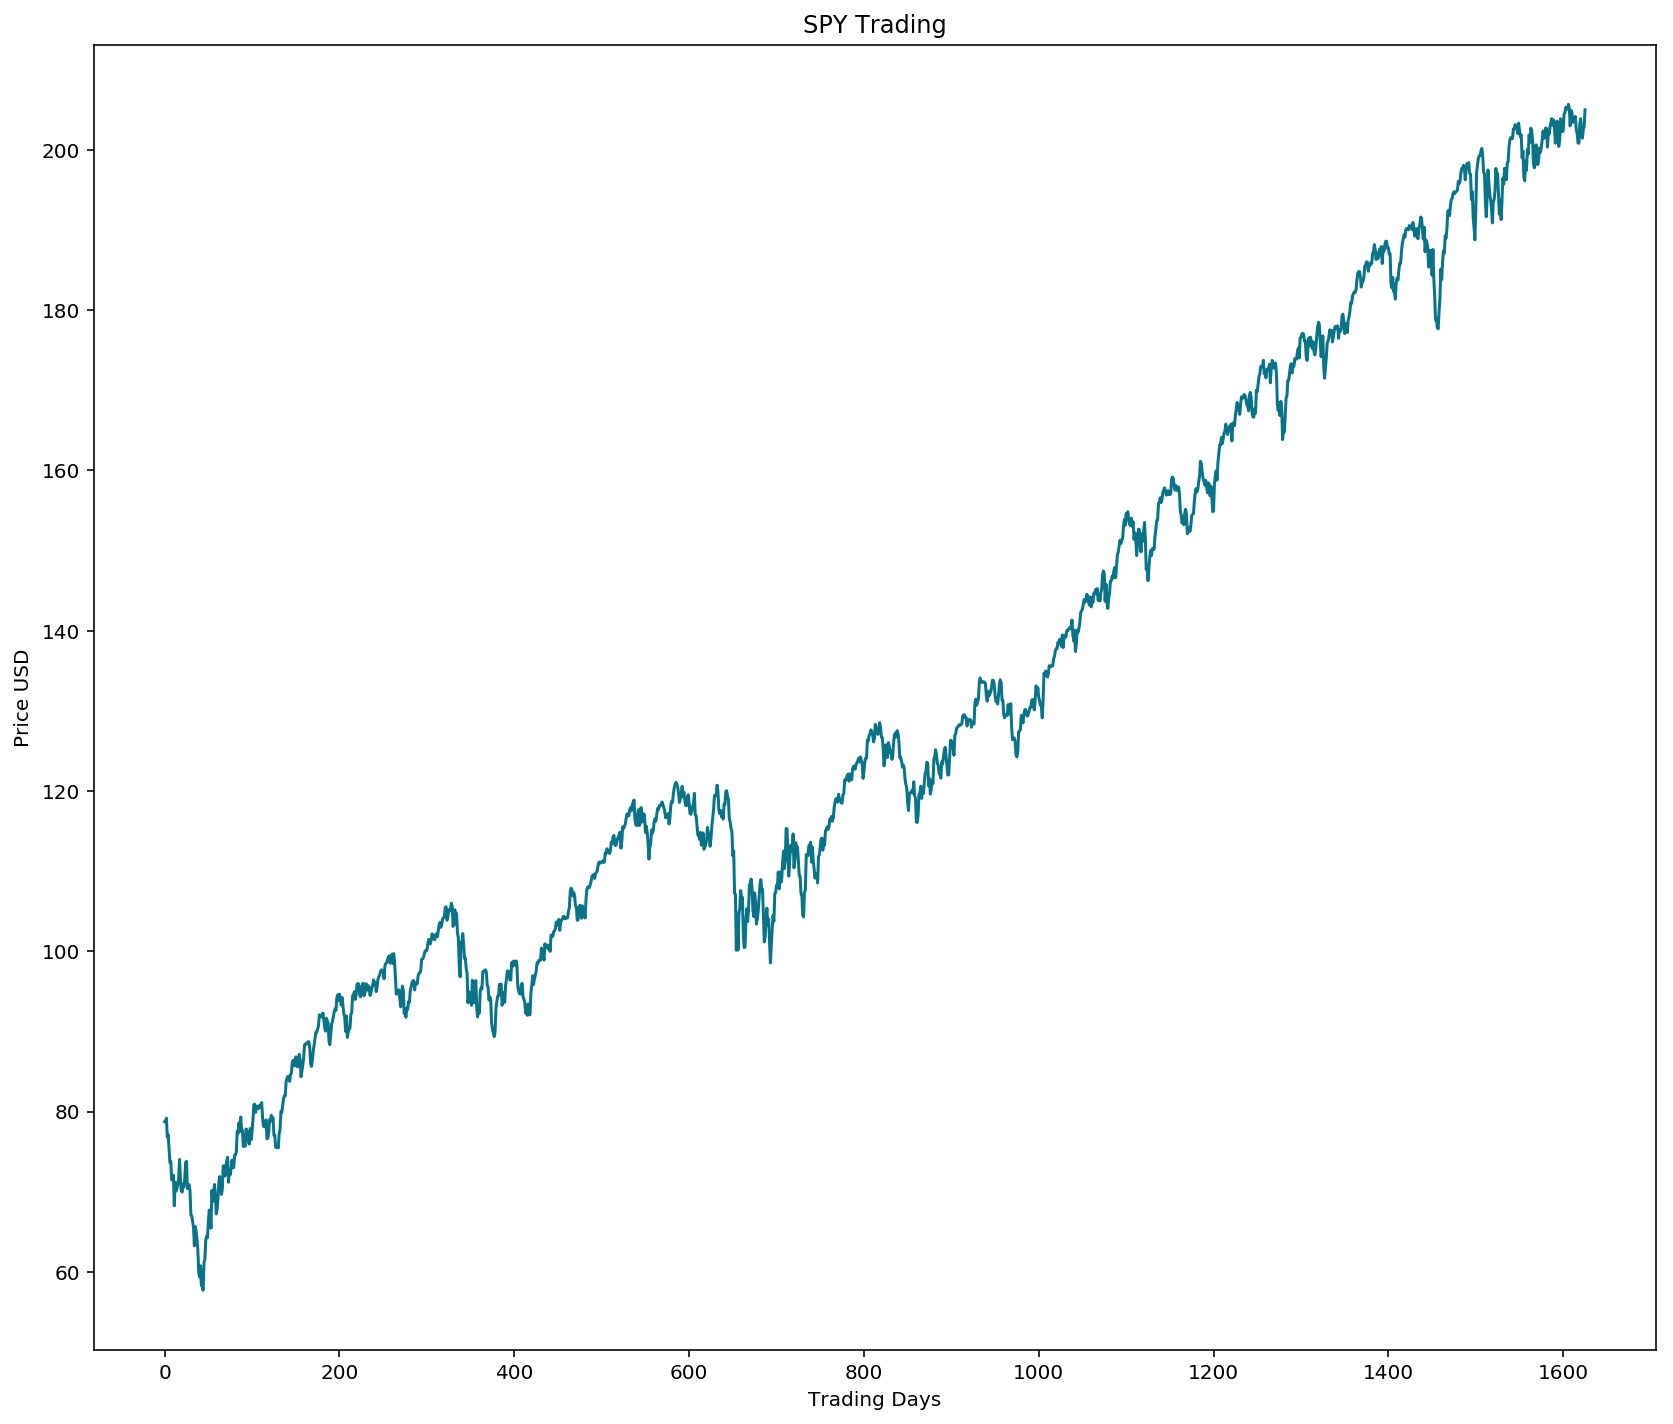

In [75]:
#Plot Basic Data
fig, ax = plt.subplots()
ax.plot(stock_df['Item'], stock_df['Adj_Close'], '#0A7388')

# format the coords message box
def price(x):
    return '$%1.2f' % x
#ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.format_ydata = price
ax.set_title(base_ticker + ' Trading')

# Add labels
plt.ylabel('Price USD')
plt.xlabel('Trading Days')

plt.show()

In [76]:
#Create numpy arrays for features and targets
X_all = []
y_all = []

#Convert dataframe columns to numpy arrays for scikit learn
for index, row in stock_df.iterrows():
    #print([np.array(row['Item'])])
    X_all.append([(row['Item'])])
    y_all.append([(row['Adj_Close'])])

#pprint(X_all)
pprint(y_all)

[[78.738477],
 [78.64530500000001],
 [79.170456],
 [76.798813],
 [77.112211],
 [75.460528],
 [73.647917],
 [73.783443],
 [71.462625],
 [71.488034],
 [72.04706],
 [68.243967],
 [71.19158],
 [70.090459],
 [70.39538399999999],
 [70.878182],
 [71.59814399999999],
 [74.020606],
 [71.615088],
 [70.158221],
 [69.94646800000001],
 [70.929001],
 [70.58172900000001],
 [71.632025],
 [73.673333],
 [73.774971],
 [70.39538399999999],
 [70.81042],
 [70.861245],
 [70.09893100000001],
 [67.100498],
 [66.939563],
 [66.21960200000001],
 [65.575869],
 [63.229642000000005],
 [65.626695],
 [65.110015],
 [64.051247],
 [62.61979],
 [59.79923],
 [59.350313],
 [60.756361],
 [58.274606999999996],
 [58.376245],
 [57.690165],
 [61.129043],
 [61.52714],
 [63.949603],
 [64.449338],
 [64.254529],
 [66.21960200000001],
 [67.70187800000001],
 [66.86333499999999],
 [65.439545],
 [70.140001],
 [68.758014],
 [69.48312800000001],
 [70.899239],
 [69.619624],
 [67.21394699999999],
 [67.836689],
 [69.150429],
 [71.172224],
 [

In [77]:
# Scale function
def scale_range(X, input_range=[0.0,1.0], target_range=[0.0,1.0]):
    """
    Scales a numpy array to a new target range
    X = array of numbers
    target_range = new target min and max, default (0.0, 1.0)
    """
    orig_range = [X.min(axis=0),X.max(axis=0)]
    orig_range = [orig_range[0][0], orig_range[1][0]]
    X_std = (X - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    X_scaled = X_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return X_scaled, orig_range
    

In [78]:
# Regularize the feature and target arrays and store min/max of input data for rescaling later
X_bounds = [min(X_all), max(X_all)]
X_bounds = [X_bounds[0][0], X_bounds[1][0]]
y_bounds = [min(y_all), max(y_all)]
y_bounds = [y_bounds[0][0], y_bounds[1][0]]

X_scaled, X_range = scale_range(np.array(X_all), input_range=X_bounds)
y_scaled, y_range = scale_range(np.array(y_all), input_range=y_bounds)

pprint(y_scaled)
print(y_range)

array([[ 0.14220896],
       [ 0.14157946],
       [ 0.14512754],
       ..., 
       [ 0.97884421],
       [ 0.98105741],
       [ 0.99531317]])
[57.690165, 205.69991200000001]


In [79]:
# Define Test/Train Split 80/20
tt_split = .20
tti_split = int(math.floor(len(stock_df['Item'])*tt_split))

# Set up training and test sets
X_train = X_scaled[:-tti_split]
X_test = X_scaled[-tti_split:]
print(len(X_train))
print(len(X_test))

y_train = y_scaled[:-tti_split]
y_test = y_scaled[-tti_split:]

#pprint(X_train)
#pprint(X_test)

# Create dataframe for all training, testing, and predicted sets
results_df = pd.DataFrame(columns=['Item', 'Actual', 'Actual_Scaled', 'Train', 'Test', 'Test_Scaled', 'Predicted', 'Predicted_Scaled'])
results_df['Item'] = stock_df['Item']
results_df['Actual'] = stock_df['Adj_Close']
results_df['Actual_Scaled'] = y_scaled.flatten()
results_df['Train'][:-tti_split] = y_train.flatten()
results_df['Test'][-tti_split:] = stock_df['Adj_Close'][-tti_split:]
results_df['Test_Scaled'][-tti_split:] = y_test.flatten()

pprint(results_df)


1301
325
      Item      Actual  Actual_Scaled      Train     Test Test_Scaled  \
0        0   78.738477       0.142209   0.142209      NaN         NaN   
1        1   78.645305       0.141579   0.141579      NaN         NaN   
2        2   79.170456       0.145128   0.145128      NaN         NaN   
3        3   76.798813       0.129104   0.129104      NaN         NaN   
4        4   77.112211       0.131221   0.131221      NaN         NaN   
5        5   75.460528       0.120062   0.120062      NaN         NaN   
6        6   73.647917       0.107816   0.107816      NaN         NaN   
7        7   73.783443       0.108731   0.108731      NaN         NaN   
8        8   71.462625       0.093051   0.093051      NaN         NaN   
9        9   71.488034       0.093223  0.0932227      NaN         NaN   
10      10   72.047060       0.097000  0.0969997      NaN         NaN   
11      11   68.243967       0.071305  0.0713048      NaN         NaN   
12      12   71.191580       0.091220  0.0

/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/gilakos/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [80]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [81]:
# Reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(X_train, look_back)
testX, testY = create_dataset(y_test, look_back)

pprint(trainX)
print('--')
#pprint(trainY)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

pprint(trainX)
print('--')
#pprint(testX)

array([[  0.00000000e+00,   6.15384615e-04,   1.23076923e-03],
       [  6.15384615e-04,   1.23076923e-03,   1.84615385e-03],
       [  1.23076923e-03,   1.84615385e-03,   2.46153846e-03],
       ..., 
       [  7.96307692e-01,   7.96923077e-01,   7.97538462e-01],
       [  7.96923077e-01,   7.97538462e-01,   7.98153846e-01],
       [  7.97538462e-01,   7.98153846e-01,   7.98769231e-01]])
--
array([[[  0.00000000e+00],
        [  6.15384615e-04],
        [  1.23076923e-03]],

       [[  6.15384615e-04],
        [  1.23076923e-03],
        [  1.84615385e-03]],

       [[  1.23076923e-03],
        [  1.84615385e-03],
        [  2.46153846e-03]],

       ..., 
       [[  7.96307692e-01],
        [  7.96923077e-01],
        [  7.97538462e-01]],

       [[  7.96923077e-01],
        [  7.97538462e-01],
        [  7.98153846e-01]],

       [[  7.97538462e-01],
        [  7.98153846e-01],
        [  7.98769231e-01]]])
--


In [88]:
# Create Keras Model
# http://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

# Create and fit the LSTM network
batch_size = 1
model = Sequential()
model.add(LSTM(8, batch_input_shape=(batch_size, look_back, 1)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=200, batch_size=batch_size, verbose=2, shuffle=False)


Epoch 1/200
5s - loss: 9.5235e-08
Epoch 2/200
5s - loss: 1.5090e-04
Epoch 3/200
5s - loss: 8.2059e-06
Epoch 4/200
5s - loss: 8.8330e-08
Epoch 5/200
5s - loss: 1.9341e-07
Epoch 6/200
5s - loss: 2.2616e-07
Epoch 7/200
5s - loss: 2.2871e-07
Epoch 8/200
5s - loss: 2.5612e-07
Epoch 9/200
5s - loss: 2.0274e-07
Epoch 10/200
5s - loss: 3.7323e-07
Epoch 11/200
5s - loss: 1.1645e-07
Epoch 12/200
5s - loss: 1.1753e-07
Epoch 13/200
5s - loss: 1.3210e-07
Epoch 14/200
5s - loss: 1.1080e-07
Epoch 15/200
5s - loss: 1.0817e-07
Epoch 16/200
5s - loss: 8.9917e-08
Epoch 17/200
5s - loss: 8.9930e-08
Epoch 18/200
5s - loss: 7.9223e-08
Epoch 19/200
5s - loss: 6.5243e-08
Epoch 20/200
5s - loss: 7.5534e-08
Epoch 21/200
5s - loss: 7.1092e-08
Epoch 22/200
5s - loss: 6.2693e-08
Epoch 23/200
5s - loss: 4.9271e-07
Epoch 24/200
5s - loss: 4.8385e-08
Epoch 25/200
5s - loss: 9.2186e-08
Epoch 26/200
5s - loss: 1.7360e-07
Epoch 27/200
5s - loss: 3.8460e-07
Epoch 28/200
5s - loss: 5.0950e-07
Epoch 29/200
5s - loss: 6.337

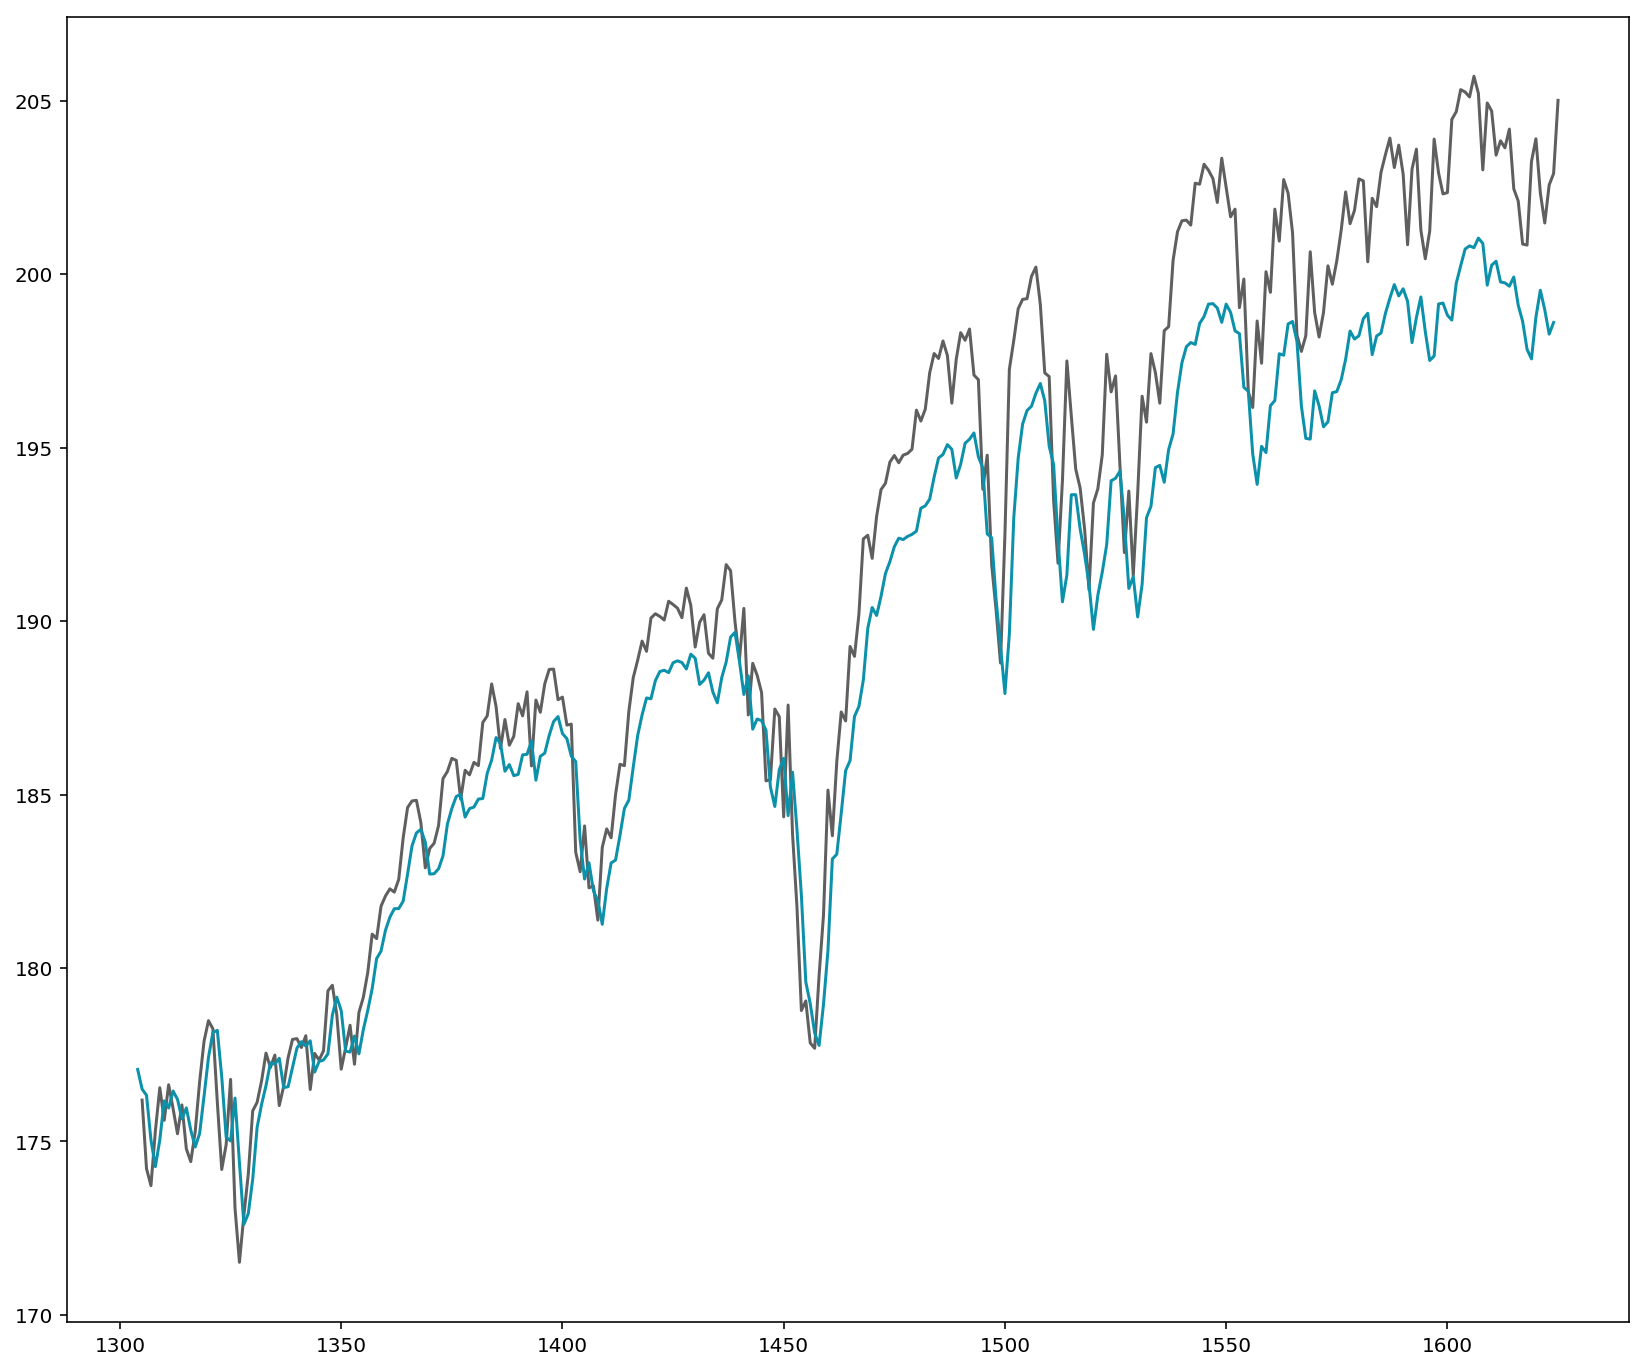

In [89]:
# Generate predictions for training
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX, batch_size=batch_size)
trainPredict_rescaled, r1 = scale_range(np.array(trainPredict), input_range=[0.0, 1.0], target_range=y_bounds)
testPredict_rescaled, r2 = scale_range(np.array(testPredict), input_range=[0.0, 1.0], target_range=y_bounds)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(X_scaled)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict_rescaled)+look_back, :] = trainPredict_rescaled
 
# shift test predictions for plotting
testPredictPlot = np.empty_like(X_scaled)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_rescaled)+(look_back*2)+1:len(X_scaled)-1, :] = testPredict_rescaled

# Create actual values in aligned array
yPlot = np.empty_like(y_scaled)
yPlot[:, :] = np.nan
yPlot[-len(testPredict_rescaled):, :] = y_all[-len(testPredict_rescaled):]

# plot baseline and predictions
plt.plot(yPlot,'#5F5F5F')
plt.plot(testPredictPlot,  '#0C91AB')
plt.show()

In [90]:
# The mean squared error
testScore = model.evaluate(testX, testY, batch_size=batch_size, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (testScore, math.sqrt(testScore)))

Test Score: 0.0003 MSE (0.0184 RMSE)


# Log of Results:
Lookback: 3

### SPY
Mean squared error: 0.0003

-- to process --

### GE
Mean squared error: 0.002


### MSFT
Mean squared error: 0.005


### AAPL
Mean squared error: 0.002

